In [8]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


#Warningds
import warnings
warnings.filterwarnings('ignore')


In [9]:
import zipfile

zip_path = "../dataset-tomat.zip"
extract_path = "/content/tomato"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [10]:
data_path = '/content/tomato'

In [11]:
filepaths = []
labels = []

In [12]:
def is_image_valid(filepath):
    try:
        img = Image.open(filepath)  # Mencoba membuka gambar
        img.verify()  # Memeriksa integritas gambar
        return True
    except (IOError, SyntaxError) as e:
        print(f"Invalid image found and skipped: {filepath}")
        return False

In [13]:
# Membaca gambar dari subfolder (Matang, Mentah, Setengah Matang)
folds = os.listdir(data_path)
for fold in folds:
    f_path = os.path.join(data_path, fold)
    filelists = os.listdir(f_path)
    for file in filelists:
        filepaths.append(os.path.join(f_path, file))

# Membaca file .jpg dari seluruh subdirektori
for root, dirs, files in os.walk(data_path):
    for file in files:
        filepath = os.path.join(root, file)
        if filepath.endswith('.jpg') and is_image_valid(filepath): # Memeriksa format gambar dan apakah gambar valid
            # Menyimpan path file dan label (nama folder induk)
            filepaths.append(filepath)
            labels.append(os.path.basename(root))  # Nama subfolder sebagai label

In [14]:
# Membuat DataFrame untuk file path dan label
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
train_df = pd.concat([Fseries, Lseries], axis=1)

In [ ]:
# Mengecek total nilai NaN di seluruh DataFrame
train_df.isna().sum().sum()

np.int64(1)

In [16]:
# Cek dan hapus baris dengan NaN jika ada
train_df.dropna(inplace=True)

In [17]:
# Memeriksa jumlah gambar setelah pembersihan
print(f"Total images after cleaning: {len(train_df)}")
print(train_df.head())  # Menampilkan beberapa baris dari DataFrame

Total images after cleaning: 6487
                                           filepaths    label
0               /content/tomato\content\ieee-mbl-cls  Damaged
1  /content/tomato\content\ieee-mbl-cls\train\Dam...  Damaged
2  /content/tomato\content\ieee-mbl-cls\train\Dam...  Damaged
3  /content/tomato\content\ieee-mbl-cls\train\Dam...  Damaged
4  /content/tomato\content\ieee-mbl-cls\train\Dam...  Damaged


In [18]:
print(train_df['label'].value_counts())

label
Old        2214
Ripe       2195
Unripe     1419
Damaged     659
Name: count, dtype: int64


In [19]:
# Split data ke training, validation, dan testing
train_df, test_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

In [20]:
# Pengaturan untuk ImageDataGenerator dan ukuran gambar
img_size = (224, 224)  # ukuran lebih kecil untuk mempercepat
batch_size = 16

In [21]:
# Augmentasi data untuk pelatihan dan uji
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='label', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='label', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='label', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size
)

Found 4150 validated image filenames belonging to 4 classes.
Found 1038 validated image filenames belonging to 4 classes.
Found 1298 validated image filenames belonging to 4 classes.


In [22]:
NUM_CLASSES = len(train_gen.class_indices)

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # transfer learning (freeze)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [25]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 117s 450ms/step - accuracy: 0.9280 - loss: 0.2177 - val_accuracy: 0.9451 - val_loss: 0.1575
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 92s 352ms/step - accuracy: 0.9381 - loss: 0.1856 - val_accuracy: 0.9499 - val_loss: 0.1402
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 91s 350ms/step - accuracy: 0.9465 - loss: 0.1631 - val_accuracy: 0.9566 - val_loss: 0.1274
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 89s 342ms/step - accuracy: 0.9482 - loss: 0.1485 - val_accuracy: 0.9586 - val_loss: 0.1165
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 89s 343ms/step - accuracy: 0.9571 - loss: 0.1341 - val_accuracy: 0.9605 - val_loss: 0.1093
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 89s 342ms/step - accuracy: 0.9600 - loss: 0.1244 - val_accuracy: 0.9644 - val_loss: 0.1032
Epoch 7/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 88s 337ms/step - accuracy: 0.9590 - loss: 0.1183 - val_accuracy: 0.9644 - val_loss: 0.0973
Epoch 8/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 89s 343ms/step - accuracy: 0.9629 - loss: 

In [26]:
import json

class_indices = train_gen.class_indices
print(class_indices)

with open("class_indices.json", "w") as f:
    json.dump(class_indices, f)

{'Damaged': 0, 'Old': 1, 'Ripe': 2, 'Unripe': 3}


In [32]:
# Ambil nama kelas dari generator
CLASS_NAMES = list(train_gen.class_indices.keys())
print(CLASS_NAMES)


['Damaged', 'Old', 'Ripe', 'Unripe']


In [33]:
def evaluate_model(model, history, model_name):

    # Prediksi
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    y_true = test_gen.classes

    # Classification Report
    print("Classification Report")
    print(classification_report(
        y_true, y_pred, target_names=CLASS_NAMES
    ))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=CLASS_NAMES,
                yticklabels=CLASS_NAMES)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Grafik Accuracy & Loss
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'Accuracy - {model_name}')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'Loss - {model_name}')
    plt.legend()

    plt.show()


82/82 ━━━━━━━━━━━━━━━━━━━━ 31s 336ms/step
Classification Report
              precision    recall  f1-score   support

     Damaged       0.98      0.91      0.94       132
         Old       0.97      0.98      0.98       443
        Ripe       0.99      0.99      0.99       439
      Unripe       0.99      1.00      1.00       284

    accuracy                           0.98      1298
   macro avg       0.98      0.97      0.98      1298
weighted avg       0.98      0.98      0.98      1298



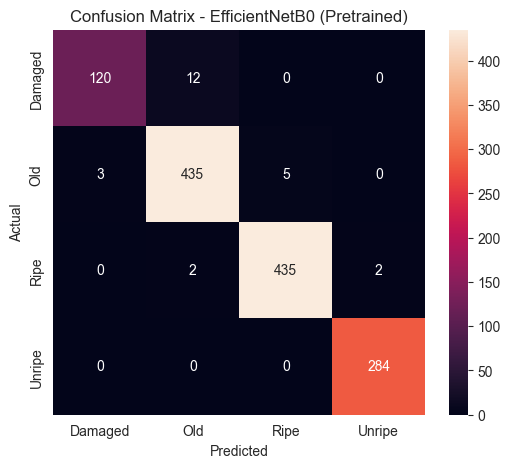

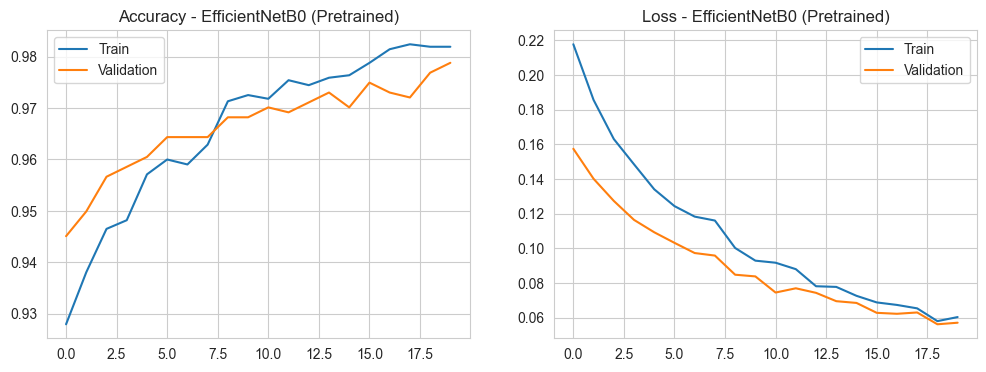

In [34]:
evaluate_model(model, history, "EfficientNetB0 (Pretrained)")

In [35]:
def save_efficient_model_h5(model, filename="efficient_model.h5"):
    model.save(filename)
    print(f"Model berhasil disimpan sebagai: {filename}")


In [36]:
save_efficient_model_h5(model)

Model berhasil disimpan sebagai: efficient_model.h5


In [37]:
from tensorflow.keras.models import load_model

def load_resnet_model(model_path):
    model = load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
    return model
